# IMPORTS

In [ ]:
!pip install tensorflow
!pip install albumentations
!pip install --upgrade tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.3/200.3 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 18.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.8/47.8 kB 906.3 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 601.3/601.3 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 49.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 65.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 74.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 347.7/347.7 kB 20.9 MB/s eta 0:00:00
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.2.0
    Uninstalling ml-dtypes-0.2.0:
      Successfully uninstalled ml-dtypes-0.2.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.15.2
    Uninstalling tensorboard-2.15.2:
      Successfully uninstalled tensorboard-2.15.2
  Attempting uninstall: kera

In [17]:
import os
import random
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Conv2D,Dense,Dropout,BatchNormalization,Flatten,MaxPool2D,MaxPooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau,ModelCheckpoint
from tensorflow.keras.regularizers import l2
from tensorflow.keras.applications import ResNet50,DenseNet121,EfficientNetB2,VGG19,Xception,VGG16
from tensorflow.keras import layers
from tensorflow.keras import Model
import cv2

# DATA Download

In [2]:
!rm -r "/content/oral-cancer-dataset.zip" #if already exists delete

rm: cannot remove '/content/oral-cancer-dataset.zip': No such file or directory


In [3]:
!pip install -q kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json     #giving permission
!kaggle datasets download -d zaidpy/oral-cancer-dataset
!unzip "/content/oral-cancer-dataset.zip" -d "/content/dataset/"  # UNZIP

cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory
Dataset URL: https://www.kaggle.com/datasets/zaidpy/oral-cancer-dataset
License(s): apache-2.0
 97% 305M/315M [00:03<00:00, 93.5MB/s]
100% 315M/315M [00:03<00:00, 90.6MB/s]
Archive:  /content/oral-cancer-dataset.zip
  inflating: /content/dataset/Oral Cancer/Oral Cancer Dataset/CANCER/001.jpeg  
  inflating: /content/dataset/Oral Cancer/Oral Cancer Dataset/CANCER/002.jpeg  
  inflating: /content/dataset/Oral Cancer/Oral Cancer Dataset/CANCER/003.jpeg  
  inflating: /content/dataset/Oral Cancer/Oral Cancer Dataset/CANCER/004.jpeg  
  inflating: /content/dataset/Oral Cancer/Oral Cancer Dataset/CANCER/005.jpeg  
  inflating: /content/dataset/Oral Cancer/Oral Cancer Dataset/CANCER/006.jpeg  
  inflating: /content/dataset/Oral Cancer/Oral Cancer Dataset/CANCER/007.jpeg  
  inflating: /content/dataset/Oral Cancer/Oral Cancer Dataset/CANCER/008.jpeg  
  inflating

# DATA MANAGEMENT

## Changing data

there are two folders so we are just shifting from old to the new dir

In [4]:
#Renaming Folder
import os
os.rename("/content/dataset/Oral Cancer/Oral Cancer Dataset/CANCER","/content/dataset/Oral Cancer/Oral Cancer Dataset/cancer")
os.rename("/content/dataset/Oral Cancer/Oral Cancer Dataset/NON CANCER","/content/dataset/Oral Cancer/Oral Cancer Dataset/non cancer")

import shutil
folder_path ="/content/dataset/Oral cancer Dataset 2.0/OC Dataset kaggle new/CANCER"
os.chdir(folder_path)
files = os.listdir()
lis=[str(file) for file in files]
for i in lis:
  os.rename("/content/dataset/Oral cancer Dataset 2.0/OC Dataset kaggle new/CANCER/"+i,"/content/dataset/Oral cancer Dataset 2.0/OC Dataset kaggle new/CANCER/"+str(0)+i)


folder_path ="/content/dataset/Oral cancer Dataset 2.0/OC Dataset kaggle new/NON CANCER"
os.chdir(folder_path)
files = os.listdir()
lis=[file for file in files]
for i in lis:
  os.rename("/content/dataset/Oral cancer Dataset 2.0/OC Dataset kaggle new/NON CANCER/"+i,"/content/dataset/Oral cancer Dataset 2.0/OC Dataset kaggle new/NON CANCER/"+str(0)+i)


In [5]:
#moving files
folder_path ="/content/dataset/Oral cancer Dataset 2.0/OC Dataset kaggle new/CANCER"
os.chdir(folder_path)
files = os.listdir()
lis=[str(file) for file in files]
for i in lis:
    shutil.move("/content/dataset/Oral cancer Dataset 2.0/OC Dataset kaggle new/CANCER/"+i,"/content/dataset/Oral Cancer/Oral Cancer Dataset/cancer")

folder_path ="/content/dataset/Oral cancer Dataset 2.0/OC Dataset kaggle new/NON CANCER"
os.chdir(folder_path)
files = os.listdir()
lis=[file for file in files]
for i in lis:
    shutil.move("/content/dataset/Oral cancer Dataset 2.0/OC Dataset kaggle new/NON CANCER/"+i,"/content/dataset/Oral Cancer/Oral Cancer Dataset/non cancer")

In [6]:
#delete corrupt fies
import os
import imghdr
count=0
path = "/content/dataset/Oral Cancer/Oral Cancer Dataset/cancer"
dir_ = os.listdir(path)
for image in dir_:
    file = os.path.join(path,image)
    if not imghdr.what(file):
        count=count+1
        os.remove(file)

path = "/content/dataset/Oral Cancer/Oral Cancer Dataset/non cancer"
dir_ = os.listdir(path)
for image in dir_:
    file = os.path.join(path,image)
    if not imghdr.what(file):
        count=count+1
        os.remove(file)
print("Corrupt files are {}".format(count))

Corrupt files are 24


In [7]:
!rm -r "/content/dataset/Oral cancer Dataset 2.0" #delete after empty
# !rm -r "/content/dataset"

## process DATA

In [8]:
def load_data(folder_path):
    images = []
    labels = []
    for label, category in enumerate(['cancer', 'non cancer']):
        category_folder = os.path.join(folder_path, category)
        for file_name in os.listdir(category_folder):
            image_path = os.path.join(category_folder, file_name)
            image = load_img(image_path, target_size=(224, 224))  # Adjust target size as needed
            image_array = img_to_array(image)
            images.append(image_array)
            labels.append(label)
    return np.array(images), np.array(labels)

folder_path = "/content/dataset/Oral Cancer/Oral Cancer Dataset"
images, labels = load_data(folder_path)


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


# Models

## 1. EXCEPTION

In [11]:
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=100, shuffle=True)

In [ ]:
base_model = Xception(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(1024, activation='relu')(x)
predictions = layers.Dense(1, activation='sigmoid')(x)  # bin classification

xception = Model(inputs=base_model.input, outputs=predictions)

xception.compile(loss='binary_crossentropy',metrics=['accuracy',tf.keras.metrics.Precision(),tf.keras.metrics.Recall()],optimizer='adam')

early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True) #reduce overfitting
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, min_lr=0.0001) # pateince
checkpoint_filepath = '/content/xception.keras'
checkpoint = ModelCheckpoint(
    checkpoint_filepath,
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
xception.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1 (Conv2D)     │ (None, 111, 111, 32)   │            864 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1_bn           │ (None, 111, 111, 32)   │            128 │ block1_conv1[0][0]     │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1_act          │ (None, 111, 111, 32)   │              0 │ block1_conv1_bn[0][0]  │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2 (Conv2D)     │ (None, 109, 109, 64)   │         18,432 │ block1_conv1_act[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2_bn           │ (None, 109, 109, 64)   │            256 │ block1_conv2[0][0]     │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2_act          │ (None, 109, 109, 64)   │              0 │ block1_conv2_bn[0][0]  │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv1           │ (None, 109, 109, 128)  │          8,768 │ block1_conv2_act[0][0] │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv1_bn        │ (None, 109, 109, 128)  │            512 │ block2_sepconv1[0][0]  │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv2_act       │ (None, 109, 109, 128)  │              0 │ block2_sepconv1_bn[0]… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv2           │ (None, 109, 109, 128)  │         17,536 │ block2_sepconv2_act[0… │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv2_bn        │ (None, 109, 109, 128)  │            512 │ block2_sepconv2[0][0]  │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 55, 55, 128)    │          8,192 │ block1_conv2_act[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_pool               │ (None, 55, 55, 128)    │              0 │ block2_sepconv2_bn[0]… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization  

 Total params: 22,960,681 (87.59 MB)

 Trainable params: 2,099,201 (8.01 MB)

 Non-trainable params: 20,861,480 (79.58 MB)

In [ ]:
print(X_train.shape)
print(X_test.shape)

(1340, 224, 224, 3)
(336, 224, 224, 3)


In [ ]:
history = xception.fit(
    x= X_train,
    y= y_train,
    epochs=100,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping, reduce_lr,checkpoint]
)

Epoch 1/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step - accuracy: 0.5612 - loss: 22.2521 - precision: 0.4750 - recall: 0.4891
Epoch 1: val_accuracy improved from -inf to 0.74405, saving model to /content/xception.keras
42/42 ━━━━━━━━━━━━━━━━━━━━ 52s 643ms/step - accuracy: 0.5619 - loss: 22.0147 - precision: 0.4759 - recall: 0.4897 - val_accuracy: 0.7440 - val_loss: 1.7106 - val_precision: 0.6403 - val_recall: 0.7120 - learning_rate: 0.0010
Epoch 2/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 0.6699 - loss: 3.6410 - precision: 0.5921 - recall: 0.6695
Epoch 2: val_accuracy did not improve from 0.74405
42/42 ━━━━━━━━━━━━━━━━━━━━ 47s 148ms/step - accuracy: 0.6707 - loss: 3.6222 - precision: 0.5931 - recall: 0.6695 - val_accuracy: 0.6815 - val_loss: 1.8873 - val_precision: 0.5455 - val_recall: 0.8640 - learning_rate: 0.0010
Epoch 3/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 0.8108 - loss: 0.8162 - precision: 0.7835 - recall: 0.7804
Epoch 3: val_accuracy improved fro

### PLOT

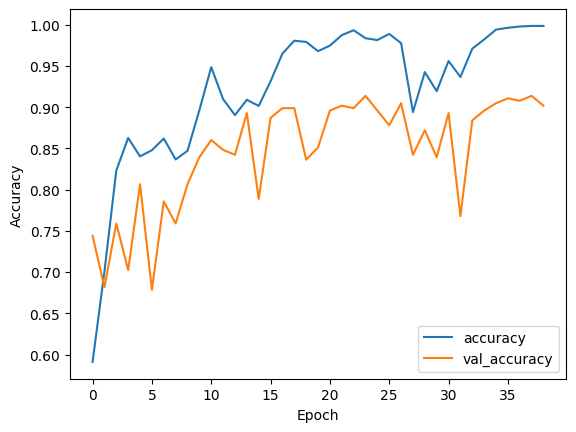

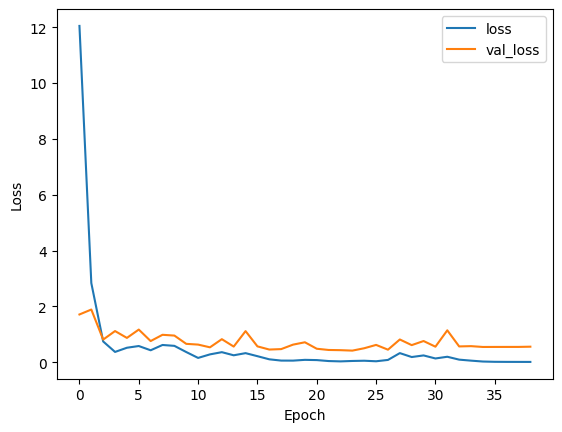

In [ ]:
# Plot accuracy and loss
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

In [16]:
pred=xception.predict(X_test)

11/11 ━━━━━━━━━━━━━━━━━━━━ 703s 64s/step


array([[8.2101747e-03],
       [9.9999571e-01],
       [9.9821788e-01],
       [2.0306367e-02],
       [3.5493527e-04],
       [9.9263495e-01],
       [9.9799132e-01],
       [3.9322529e-02],
       [6.2919143e-03],
       [9.7901696e-01],
       [5.7184980e-03],
       [6.5573946e-02],
       [9.1363180e-01],
       [7.6987721e-02],
       [4.2101784e-04],
       [3.1657360e-04],
       [5.5461835e-02],
       [3.0347556e-04],
       [2.9394684e-02],
       [5.6504188e-03],
       [9.5341634e-04],
       [1.7405666e-05],
       [4.7314274e-01],
       [9.9969721e-01],
       [1.1020721e-04],
       [8.3749867e-08],
       [9.8000920e-01],
       [5.2454585e-04],
       [3.3065469e-05],
       [6.7413743e-03],
       [9.9713993e-01],
       [2.8536762e-03],
       [9.5944369e-01],
       [9.9915171e-01],
       [8.9563866e-04],
       [1.0782723e-04],
       [1.6227402e-04],
       [6.4451308e-03],
       [9.9791437e-01],
       [1.6015333e-04],
       [9.9953365e-01],
       [1.064643

60


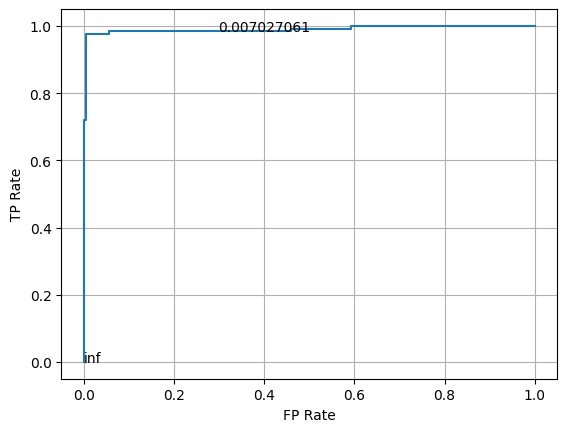

In [ ]:
fp,tp,thresholds=roc_curve(y_test,pred)
plt.plot(fp,tp)
plt.xlabel("FP Rate")
plt.ylabel("TP Rate")
print(len(thresholds))
plt.grid()
skip=30
for i in range(0,len(thresholds),skip):
  plt.text(fp[i],tp[i],thresholds[i])
plt.show()

### Loading and Testing

In [10]:
sception_new = tf.keras.models.load_model('/content/xception.keras')

# Show the model architecture
sception_new.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1 (Conv2D)     │ (None, 111, 111, 32)   │            864 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1_bn           │ (None, 111, 111, 32)   │            128 │ block1_conv1[0][0]     │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1_act          │ (None, 111, 111, 32)   │              0 │ block1_conv1_bn[0][0]  │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2 (Conv2D)     │ (None, 109, 109, 64)   │         18,432 │ block1_conv1_act[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2_bn           │ (None, 109, 109, 64)   │            256 │ block1_conv2[0][0]     │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2_act          │ (None, 109, 109, 64)   │              0 │ block1_conv2_bn[0][0]  │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv1           │ (None, 109, 109, 128)  │          8,768 │ block1_conv2_act[0][0] │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv1_bn        │ (None, 109, 109, 128)  │            512 │ block2_sepconv1[0][0]  │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv2_act       │ (None, 109, 109, 128)  │              0 │ block2_sepconv1_bn[0]… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv2           │ (None, 109, 109, 128)  │         17,536 │ block2_sepconv2_act[0… │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv2_bn        │ (None, 109, 109, 128)  │            512 │ block2_sepconv2[0][0]  │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 55, 55, 128)    │          8,192 │ block1_conv2_act[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_pool               │ (None, 55, 55, 128)    │              0 │ block2_sepconv2_bn[0]… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization  

 Total params: 27,159,085 (103.60 MB)

 Trainable params: 2,099,201 (8.01 MB)

 Non-trainable params: 20,861,480 (79.58 MB)

 Optimizer params: 4,198,404 (16.02 MB)

0- cancer, 0.4< non cancer

In [ ]:
CLASS_NAMES=['cancer','non cancer']
test_img=cv2.imread("/content/dataset/Oral Cancer/Oral Cancer Dataset/cancer/047.jpeg")
test_img= cv2.resize(test_img,(224,224))
test_img= tf.expand_dims(test_img,axis=0)
print(CLASS_NAMES[tf.argmax(sception_new(test_img),axis=-1).numpy()[0]])
sception_new.predict(test_img)[0][0]

cancer
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


0.0025477076

## 2. Resnet_50

In [ ]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(1024, activation='relu')(x)
predictions = layers.Dense(1, activation='sigmoid')(x)  # bin classification

model_resnet50 = Model(inputs=base_model.input, outputs=predictions)

model_resnet50.compile(loss='binary_crossentropy',metrics=['accuracy',tf.keras.metrics.Precision(),tf.keras.metrics.Recall()],optimizer='adam')

early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True) #reduce overfitting
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, min_lr=0.0001) # pateince
checkpoint_filepath = '/content/best_model_resnet.keras'
checkpoint = ModelCheckpoint(
    checkpoint_filepath,
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

In [ ]:
model_resnet50.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 56, 56, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 56, 56, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)             

 Total params: 25,686,913 (97.99 MB)

 Trainable params: 2,099,201 (8.01 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [ ]:
print(X_train.shape)
print(X_test.shape)

(1340, 224, 224, 3)
(336, 224, 224, 3)


In [ ]:
# Train the model
history = model_resnet50.fit(
    x= X_train,
    y= y_train,
    epochs=50,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping, reduce_lr,checkpoint]
)

Epoch 1/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step - accuracy: 0.7745 - loss: 0.7307 - precision_2: 0.7347 - recall_2: 0.7289
Epoch 1: val_accuracy improved from -inf to 0.88988, saving model to /content/best_model_resnet.keras
42/42 ━━━━━━━━━━━━━━━━━━━━ 30s 431ms/step - accuracy: 0.7763 - loss: 0.7251 - precision_2: 0.7368 - recall_2: 0.7311 - val_accuracy: 0.8899 - val_loss: 0.2755 - val_precision_2: 0.9889 - val_recall_2: 0.7120 - learning_rate: 0.0010
Epoch 2/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 0.9190 - loss: 0.2305 - precision_2: 0.9283 - recall_2: 0.8797
Epoch 2: val_accuracy improved from 0.88988 to 0.96429, saving model to /content/best_model_resnet.keras
42/42 ━━━━━━━━━━━━━━━━━━━━ 24s 149ms/step - accuracy: 0.9194 - loss: 0.2294 - precision_2: 0.9285 - recall_2: 0.8804 - val_accuracy: 0.9643 - val_loss: 0.1319 - val_precision_2: 0.9748 - val_recall_2: 0.9280 - learning_rate: 0.0010
Epoch 3/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 0.9498 - loss

### PLOT

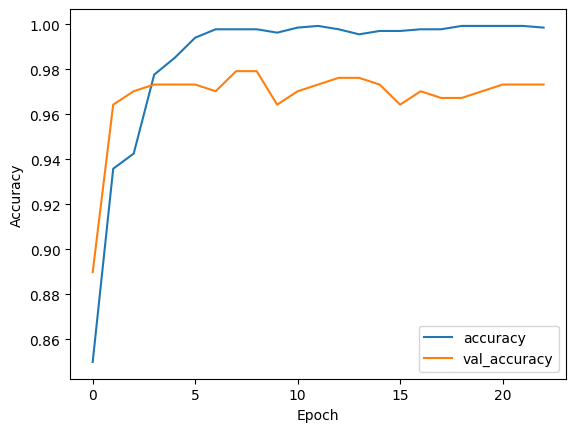

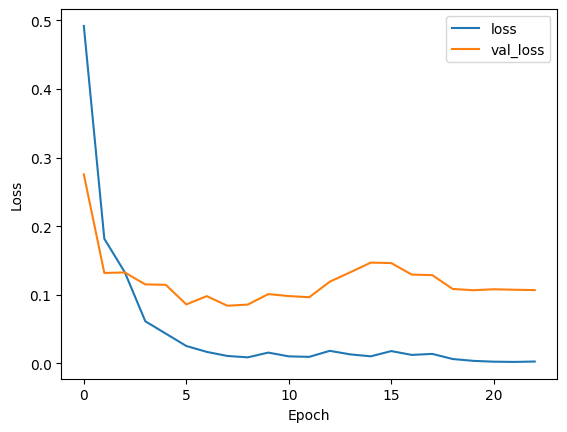

In [ ]:
# Plot accuracy and loss
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

In [ ]:
model_resnet50.evaluate(X_test,y_test)

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step - accuracy: 0.9754 - loss: 0.1214 - precision_2: 0.9825 - recall_2: 0.9507


[0.08417381346225739,
 0.9791666865348816,
 0.9836065769195557,
 0.9599999785423279]

### Loading and Testing

In [ ]:
new_model_resnet50 = tf.keras.models.load_model('/content/best_model_resnet.keras')

new_model_resnet50.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 56, 56, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 56, 56, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)             

 Total params: 29,885,317 (114.00 MB)

 Trainable params: 2,099,201 (8.01 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

 Optimizer params: 4,198,404 (16.02 MB)

In [ ]:
new_model_resnet50.evaluate(X_test,y_test)

11/11 ━━━━━━━━━━━━━━━━━━━━ 8s 294ms/step - accuracy: 0.9754 - loss: 0.1214 - precision_2: 0.9825 - recall_2: 0.9507


[0.08417381346225739,
 0.9791666865348816,
 0.9836065769195557,
 0.9599999785423279]

0- cancer, 0.4< non cancer

In [ ]:
CLASS_NAMES=['cancer','non cancer']
test_img=cv2.imread("/content/dataset/Oral Cancer/Oral Cancer Dataset/cancer/047.jpeg")
test_img= cv2.resize(test_img,(224,224))
test_img= tf.expand_dims(test_img,axis=0)
print(CLASS_NAMES[tf.argmax(new_model_resnet50(test_img),axis=-1).numpy()[0]])
model_resnet50.predict(test_img)[0][0]

cancer
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


0.002579688

## 3. EfficientNetB2

In [ ]:
base_model = EfficientNetB2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(1024, activation='relu')(x)
predictions = layers.Dense(1, activation='sigmoid')(x)

model_EfficientNetB2 = Model(inputs=base_model.input, outputs=predictions)

model_EfficientNetB2.compile(loss='binary_crossentropy',metrics=['accuracy',tf.keras.metrics.Precision(),tf.keras.metrics.Recall()],optimizer='adam')

early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, min_lr=0.0001)
checkpoint_filepath = '/content/efficient_net_B2.keras'
checkpoint = ModelCheckpoint(
    checkpoint_filepath,
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

31790344/31790344 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
history = model_EfficientNetB2.fit(
    x= X_train,
    y= y_train,
    epochs=50,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping, reduce_lr,checkpoint]
)

Epoch 1/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 511ms/step - accuracy: 0.7865 - loss: 0.3879 - precision_3: 0.7413 - recall_3: 0.6948
Epoch 1: val_accuracy improved from -inf to 0.93750, saving model to /content/efficient_net_B2.keras
42/42 ━━━━━━━━━━━━━━━━━━━━ 81s 1s/step - accuracy: 0.7882 - loss: 0.3862 - precision_3: 0.7436 - recall_3: 0.6972 - val_accuracy: 0.9375 - val_loss: 0.1894 - val_precision_3: 0.9308 - val_recall_3: 0.9367 - learning_rate: 0.0010
Epoch 2/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.9419 - loss: 0.1689 - precision_3: 0.9398 - recall_3: 0.9148
Epoch 2: val_accuracy improved from 0.93750 to 0.94048, saving model to /content/efficient_net_B2.keras
42/42 ━━━━━━━━━━━━━━━━━━━━ 21s 106ms/step - accuracy: 0.9418 - loss: 0.1689 - precision_3: 0.9396 - recall_3: 0.9146 - val_accuracy: 0.9405 - val_loss: 0.1674 - val_precision_3: 0.9259 - val_recall_3: 0.9494 - learning_rate: 0.0010
Epoch 3/50
41/42 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.9611 - loss: 0.1

### PLOT

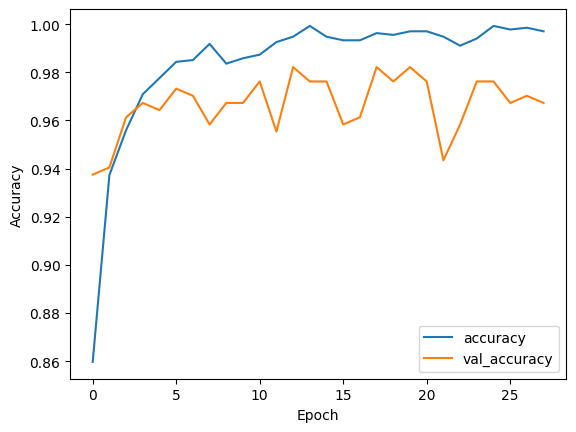

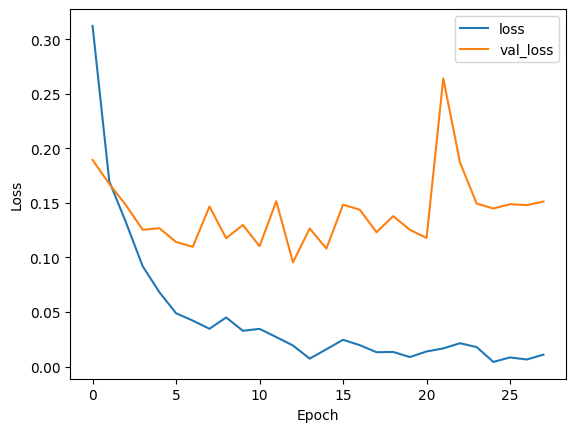

In [ ]:
# Plot accuracy and loss
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

In [ ]:
model_EfficientNetB2.evaluate(X_test,y_test)

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - accuracy: 0.9850 - loss: 0.1424 - precision_3: 0.9970 - recall_3: 0.9724


[0.09551351517438889,
 0.9821428656578064,
 0.9935064911842346,
 0.9683544039726257]

### Testing

0-cancer 0.4<-non cancer

In [ ]:
# test_img=cv2.imread("/content/dataset/Oral Cancer/Oral Cancer Dataset/cancer/005.jpeg")   #cancer
test_img=cv2.imread("/content/dataset/Oral Cancer/Oral Cancer Dataset/non cancer/003.jpeg")  #non cancer
test_img= cv2.resize(test_img,(224,224))
test_img= tf.expand_dims(test_img,axis=0)
model_EfficientNetB2.predict(test_img)[0][0]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


0.8056433

## 4. VGG 19

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=100, shuffle=True)

base_model = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.5)(x)  # Adding dropout for regularization
predictions = layers.Dense(1, activation='sigmoid')(x)

model_VGG19 = Model(inputs=base_model.input, outputs=predictions)
model_VGG19.compile(loss='binary_crossentropy',metrics=['accuracy',tf.keras.metrics.Precision(),tf.keras.metrics.Recall()],optimizer='adam')

early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, min_lr=0.00001)
checkpoint_filepath = '/content/vgg19.keras'
checkpoint = ModelCheckpoint(
    checkpoint_filepath,
    monitor='val_accuracy',  # Save the model based on validation accuracy
    save_best_only=True,      # Only save the best model
    mode='max',               # Save the model when the monitored quantity is maximized
    verbose=1
)

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
history = model_VGG19.fit(
    x= X_train,
    y= y_train,
    epochs=50,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping, reduce_lr,checkpoint]
)

Epoch 1/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 482ms/step - accuracy: 0.6274 - loss: 3.9763 - precision_4: 0.5375 - recall_4: 0.5549
Epoch 1: val_accuracy improved from -inf to 0.88393, saving model to /content/vgg19.keras
42/42 ━━━━━━━━━━━━━━━━━━━━ 50s 792ms/step - accuracy: 0.6303 - loss: 3.9339 - precision_4: 0.5413 - recall_4: 0.5583 - val_accuracy: 0.8839 - val_loss: 0.4917 - val_precision_4: 0.8221 - val_recall_4: 0.9306 - learning_rate: 0.0010
Epoch 2/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step - accuracy: 0.8798 - loss: 0.4180 - precision_4: 0.8451 - recall_4: 0.8670
Epoch 2: val_accuracy did not improve from 0.88393
42/42 ━━━━━━━━━━━━━━━━━━━━ 42s 195ms/step - accuracy: 0.8798 - loss: 0.4180 - precision_4: 0.8452 - recall_4: 0.8666 - val_accuracy: 0.8601 - val_loss: 0.4758 - val_precision_4: 0.7650 - val_recall_4: 0.9722 - learning_rate: 0.0010
Epoch 3/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - accuracy: 0.8749 - loss: 0.3839 - precision_4: 0.8267 - recall_4: 0.8713
Epoch 3: val_a

### PLOT

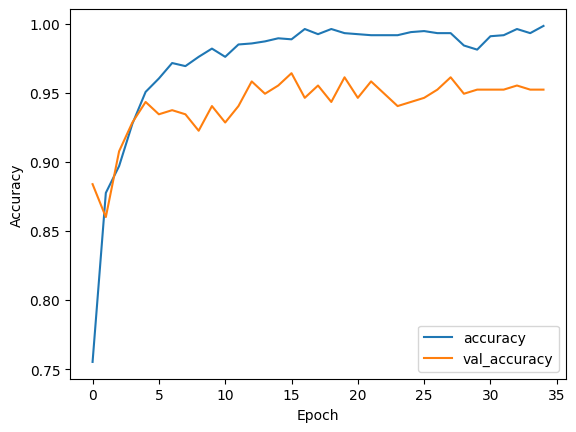

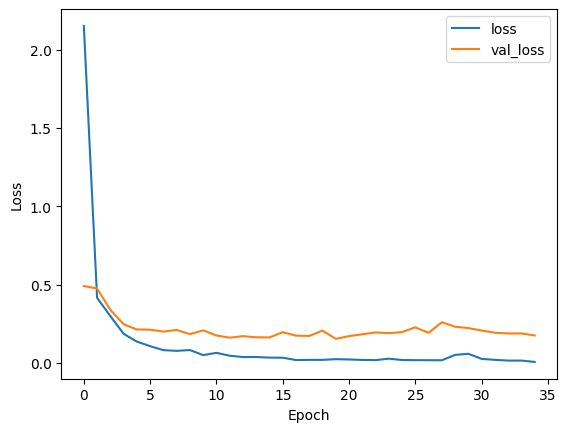

In [ ]:
# Plot accuracy and loss
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

### test

In [ ]:
validation_dataset=(X_test,y_test)
CLASS_NAMES=["CANCER","NON CANCER"]

In [ ]:
new_model_vgg19 = tf.keras.models.load_model('/content/vgg19.keras')

# Show the model architecture
new_model_vgg19.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv4 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv4 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv4 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 21,603,397 (82.41 MB)

 Trainable params: 526,337 (2.01 MB)

 Non-trainable params: 20,024,384 (76.39 MB)

 Optimizer params: 1,052,676 (4.02 MB)

In [ ]:
dataset = tf.data.Dataset.from_tensor_slices(validation_dataset)

In [ ]:
dataset.as_numpy_iterator()

NumpyIterator(iterator=<tensorflow.python.data.ops.iterator_ops.OwnedIterator object at 0x7eb0b97e6b60>)

In [ ]:
len(list(dataset.as_numpy_iterator()))

336

In [ ]:
def prediction_to_name(data):
  if(data>0.4):  #threshold =0.4
    return 1
  else:
    return 0

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


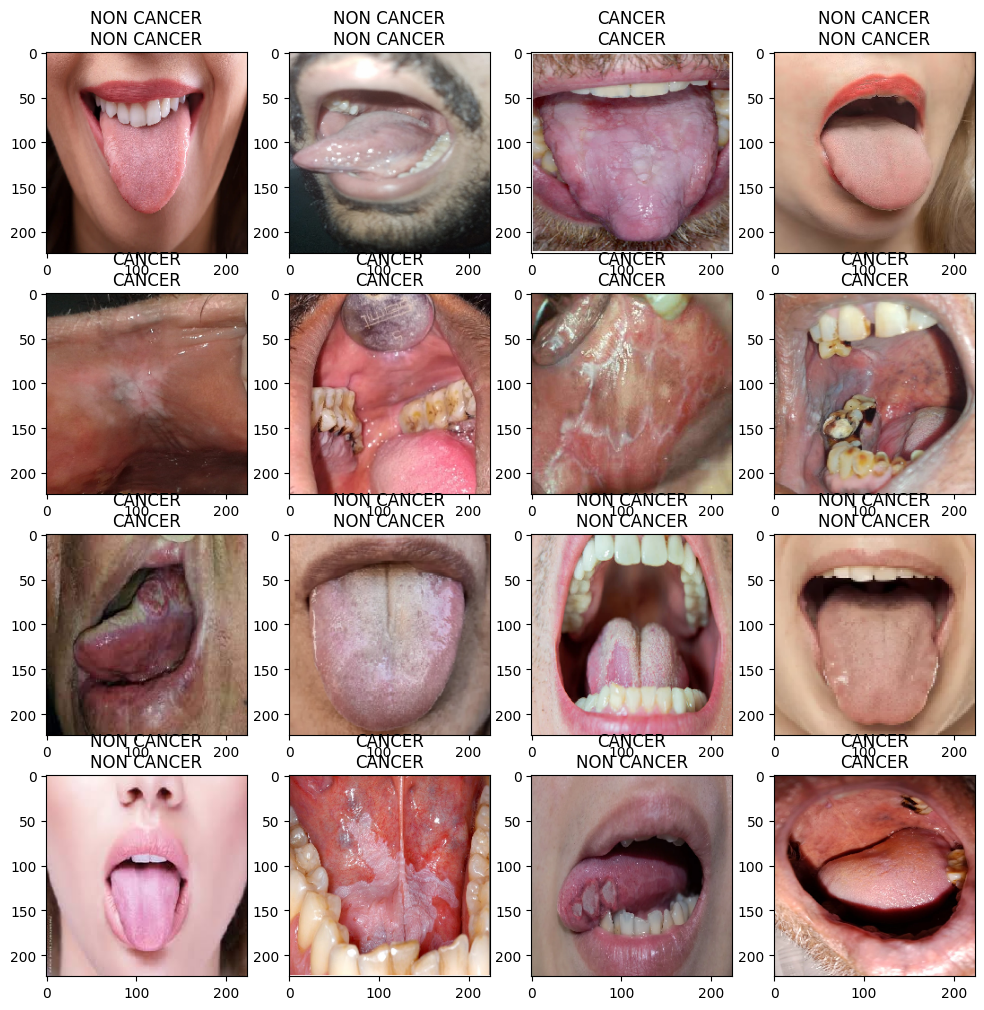

In [ ]:
plt.figure(figsize=(12,12))
for i, (image,label) in enumerate(dataset.take(16)):  #i= 1-16
  ax=plt.subplot(4,4,i+1)
  plt.imshow(image/255.0)
    # plt.imshow(np.clip(image, 0, 1))
  # plt.title(dataset_info.features['label'].int2str(label))
  plt.title(CLASS_NAMES[label] + "\n"+ CLASS_NAMES[prediction_to_name(new_model_vgg19.predict(np.expand_dims(image, axis=0))[0][0])])

## VGG16

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=100, shuffle=True)

base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(1024, activation='relu')(x)
predictions = layers.Dense(1, activation='sigmoid')(x)  # bin classification

vgg16 = Model(inputs=base_model.input, outputs=predictions)

vgg16.compile(loss='binary_crossentropy',metrics=['accuracy',tf.keras.metrics.Precision(),tf.keras.metrics.Recall()],optimizer='adam')

early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True) #reduce overfitting
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, min_lr=0.000001) # pateince
checkpoint_filepath = '/content/vgg16.keras'
checkpoint = ModelCheckpoint(
    checkpoint_filepath,
    monitor='val_accuracy',  # Save the model based on validation accuracy
    save_best_only=True,      # Only save the best model
    mode='max',               # Save the model when the monitored quantity is maximized
    verbose=1
)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
vgg16.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_5           │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 1024)                │         525,3

 Total params: 15,241,025 (58.14 MB)

 Trainable params: 526,337 (2.01 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [ ]:
print(X_train.shape)
print(X_test.shape)

(1340, 224, 224, 3)
(336, 224, 224, 3)


In [ ]:
# Train the model
history = vgg16.fit(
    x= X_train,
    y= y_train,
    epochs=100,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping, reduce_lr,checkpoint]
)

Epoch 1/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - accuracy: 0.6491 - loss: 4.1899 - precision_5: 0.5498 - recall_5: 0.5623
Epoch 1: val_accuracy improved from -inf to 0.83929, saving model to /content/vgg16.keras
42/42 ━━━━━━━━━━━━━━━━━━━━ 18s 361ms/step - accuracy: 0.6518 - loss: 4.1411 - precision_5: 0.5539 - recall_5: 0.5659 - val_accuracy: 0.8393 - val_loss: 0.5538 - val_precision_5: 0.7126 - val_recall_5: 0.9520 - learning_rate: 0.0010
Epoch 2/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 0.9095 - loss: 0.2800 - precision_5: 0.8831 - recall_5: 0.9121
Epoch 2: val_accuracy improved from 0.83929 to 0.89881, saving model to /content/vgg16.keras
42/42 ━━━━━━━━━━━━━━━━━━━━ 18s 337ms/step - accuracy: 0.9093 - loss: 0.2802 - precision_5: 0.8830 - recall_5: 0.9117 - val_accuracy: 0.8988 - val_loss: 0.3405 - val_precision_5: 0.9892 - val_recall_5: 0.7360 - learning_rate: 0.0010
Epoch 3/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 0.9504 - loss: 0.1464 - precisio

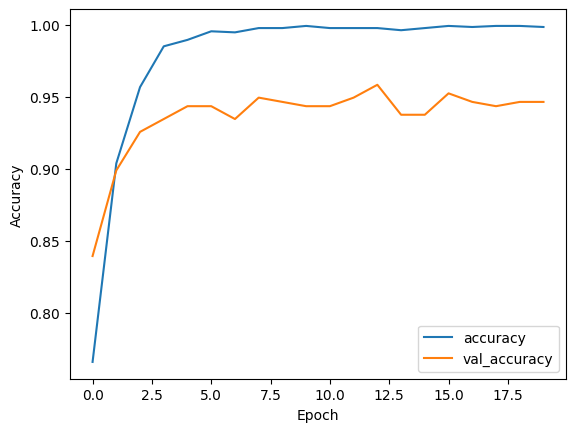

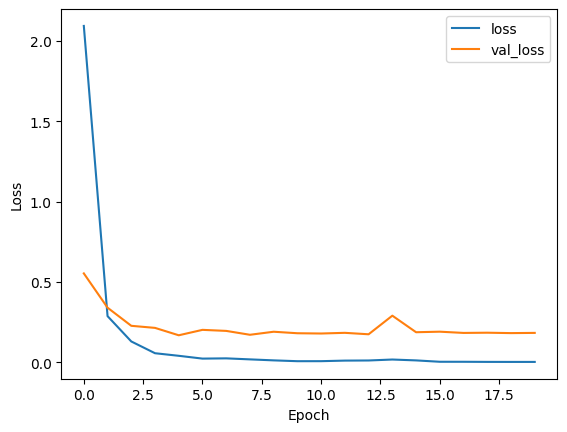

In [ ]:
# Plot accuracy and loss
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

### Loading and Testing

In [ ]:
vgg16_new = tf.keras.models.load_model('/content/vgg16.keras')

# Show the model architecture
vgg16_new.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_5           │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 1024)                │         525,3

 Total params: 16,293,701 (62.16 MB)

 Trainable params: 526,337 (2.01 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

 Optimizer params: 1,052,676 (4.02 MB)

In [ ]:
sception_new.evaluate(X_test,y_test)

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 122ms/step - accuracy: 0.9090 - loss: 0.5188 - precision: 0.9213 - recall: 0.8284


[0.4163717031478882, 0.913690447807312, 0.9285714030265808, 0.8320000171661377]

### TESTING

In [ ]:
CLASS_NAMES=['cancer','non cancer']
test_img=cv2.imread("/content/dataset/Oral Cancer/Oral Cancer Dataset/cancer/047.jpeg")
test_img= cv2.resize(test_img,(224,224))
test_img= tf.expand_dims(test_img,axis=0)
print(CLASS_NAMES[tf.argmax(new_model_resnet50(test_img),axis=-1).numpy()[0]])
sception_new.predict(test_img)[0][0]

cancer
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


0.0025477076

## Custom Model

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.model_selection import train_test_split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=100, shuffle=True)

### CNN MODEL

In [ ]:
model= tf.keras.Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    Conv2D(64, (3, 3), activation='relu'),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    Conv2D(128, (3, 3), activation='relu'),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid'),
])
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)                    │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 220, 220, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 110, 110, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 108, 108, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 106, 106, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 53, 53, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 51, 51, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 49, 49, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 24, 24, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 73728)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 512)                 │      37,749,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │             513 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 38,036,769 (145.10 MB)

 Trainable params: 38,036,769 (145.10 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)  # Reduce overfitting
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, min_lr=0.000001)  # Reduce learning rate
checkpoint_filepath = '/content/cnn_model.keras'
checkpoint = ModelCheckpoint(
    checkpoint_filepath,
    monitor='val_accuracy',  # Save the model based on validation accuracy
    save_best_only=True,      # Only save the best model
    mode='max',               # Save the model when the monitored quantity is maximized
    verbose=1
)

### TRAIN

In [ ]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=50,
    batch_size=32,
    callbacks=[early_stopping, reduce_lr, checkpoint],
    verbose=1
)

Epoch 1/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5388 - loss: 28.3218 - precision_1: 0.4624 - recall_1: 0.4790
Epoch 1: val_accuracy improved from -inf to 0.72024, saving model to /content/cnn_model.keras
42/42 ━━━━━━━━━━━━━━━━━━━━ 59s 1s/step - accuracy: 0.5398 - loss: 27.8809 - precision_1: 0.4635 - recall_1: 0.4798 - val_accuracy: 0.7202 - val_loss: 0.6121 - val_precision_1: 0.8605 - val_recall_1: 0.2960 - learning_rate: 0.0010
Epoch 2/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7280 - loss: 0.6144 - precision_1: 0.7277 - recall_1: 0.5129
Epoch 2: val_accuracy improved from 0.72024 to 0.73810, saving model to /content/cnn_model.keras
42/42 ━━━━━━━━━━━━━━━━━━━━ 56s 1s/step - accuracy: 0.7280 - loss: 0.6144 - precision_1: 0.7282 - recall_1: 0.5134 - val_accuracy: 0.7381 - val_loss: 0.6319 - val_precision_1: 0.6609 - val_recall_1: 0.6080 - learning_rate: 0.0010
Epoch 3/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7360 - loss: 0.5941 - precision_1: 0.6

### ACC,ROC,CONF

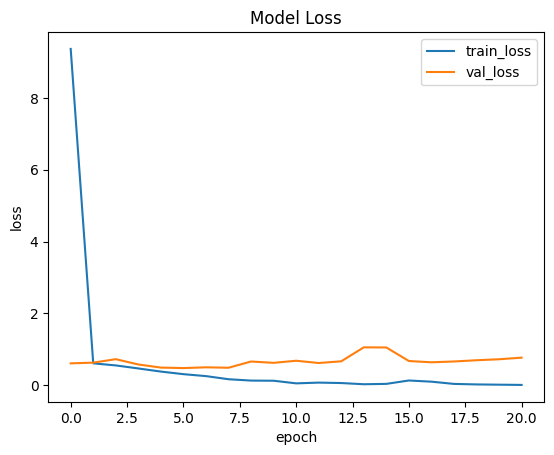

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss','val_loss'])
plt.show()

In [ ]:
pred=model.predict(X_test)

11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 166ms/step


In [ ]:
pred

array([[3.76484066e-01],
       [5.31220973e-01],
       [9.99991894e-01],
       [7.53589571e-02],
       [1.62044883e-01],
       [7.66832471e-01],
       [8.29048514e-01],
       [3.05695057e-01],
       [7.42384374e-01],
       [6.16704524e-01],
       [1.86627150e-01],
       [3.02611053e-01],
       [9.99472797e-01],
       [2.27222472e-01],
       [2.66315520e-01],
       [3.03527173e-02],
       [3.66539806e-01],
       [1.25306025e-02],
       [7.27687925e-02],
       [1.89210162e-01],
       [7.82805741e-01],
       [2.25541949e-01],
       [1.90183580e-01],
       [3.03982705e-01],
       [3.24478686e-01],
       [1.41108885e-01],
       [9.14602637e-01],
       [1.26134446e-14],
       [2.19991073e-01],
       [3.91191877e-02],
       [9.92185891e-01],
       [4.50026929e-01],
       [9.30935502e-01],
       [9.88828182e-01],
       [3.43055487e-01],
       [2.15965081e-02],
       [5.85631691e-02],
       [5.83936334e-01],
       [9.49683845e-01],
       [3.65523845e-01],


111


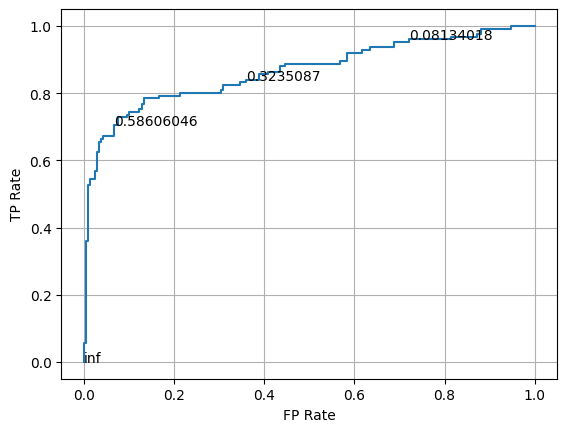

In [ ]:
from sklearn.metrics import confusion_matrix, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
fp,tp,thresholds=roc_curve(y_test,pred)
plt.plot(fp,tp)
plt.xlabel("FP Rate")
plt.ylabel("TP Rate")
print(len(thresholds))
plt.grid()
skip=30
for i in range(0,len(thresholds),skip):
  plt.text(fp[i],tp[i],thresholds[i])
plt.show()

[[197  14]
 [ 38  87]]


Text(0.5, 58.7222222222222, 'Predicted')

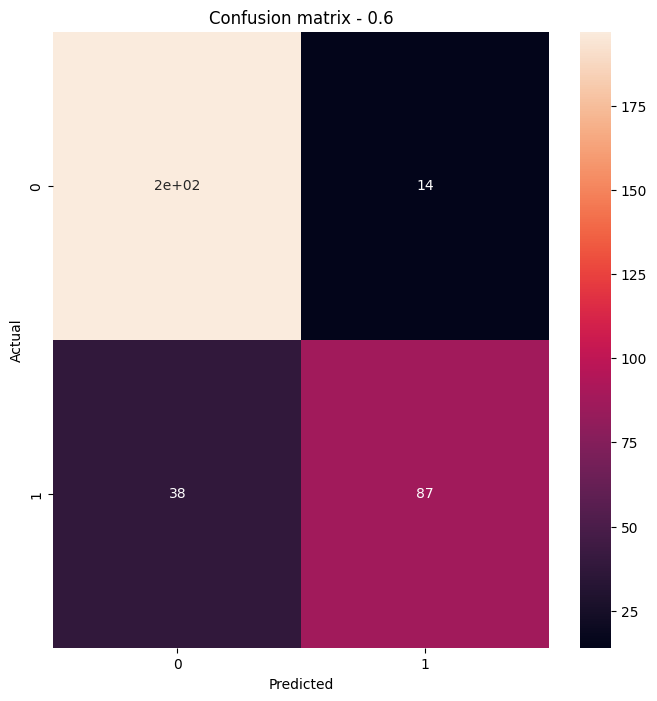

In [ ]:
from sklearn.metrics import confusion_matrix, roc_curve
import seaborn as sns
thresh=0.60
y_pred = (pred > thresh).astype(int)
# y_pred
cm=confusion_matrix(y_test,y_pred)
threshold=thresh
print(cm)
plt.figure(figsize=(8,8))
sns.heatmap(cm,annot=True,)
plt.title('Confusion matrix - {}'.format(threshold))
plt.ylabel('Actual')
plt.xlabel('Predicted')